# CNC Anomaly Detection

In this project, we will be analyzing multiple diagnostic tests of a CNC machine and detecting where the machine is malfunctioning. 
It is given that the faults are on the b-axis and lines 35-45 of the machine. 
(Data has been adjusted for privacy reasons)

k-means clustering with dynamic time warping will be used to cluster the diagnostic tests, and create centroid clusters. The tests that have the greatest difference from their respective centroid will be classified as a malfunction.

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tslearn.clustering import TimeSeriesKMeans



# Load in Data

In [ ]:
mc1 = pd.read_csv('/data/mc1_data.csv.zip')

In [ ]:
#Locating lines where malfunctions are occurring
mc1 = mc1.loc[(mc1['LINE_NUM'] == 35) | (mc1['LINE_NUM'] == 40) | (mc1['LINE_NUM'] == 45)].reset_index(drop=True)

# Creating 3d Array From Data (n_ts, sz, d)

In order to perform multidimensional clustering, we need to create a three dimensional array from our data.
It needs to be arranged in the following order:

(number of tests, size of each test, b-axis data)

In [ ]:
#filter where malfunctions are occurring
df = mc1.filter(['DateTime','B_AXIS_CURR']).reset_index().rename(columns={'index': 'ms'})

In [ ]:
cols = list(df.columns.values)
cols

['ms', 'DateTime', 'B_AXIS_CURR']

ms = millisecond in the test

In [ ]:
df.shape

(32494, 3)

In [ ]:
df.head()

,ms,DateTime,B_AXIS_CURR
0,0,2019-07-02 16:30:08,0.9384
1,1,2019-07-02 16:30:08,0.8432
2,2,2019-07-02 16:30:08,0.8500
3,3,2019-07-02 16:30:08,0.8704
4,4,2019-07-02 16:30:08,1.1424


In [ ]:
#Transform DateTimes to Labels
label_encoder = LabelEncoder()
date_labels = label_encoder.fit_transform(df['DateTime'])
df['dateId'] = date_labels
df.drop(columns='DateTime', inplace=True)
df = df[['dateId','ms', 'B_AXIS_CURR']]
df

,dateId,ms,B_AXIS_CURR
0,0,0,0.9384
1,0,1,0.8432
2,0,2,0.8500
3,0,3,0.8704
4,0,4,1.1424
...,...,...,...
32489,60,32489,0.8840
32490,60,32490,0.6936
32491,60,32491,0.5576
32492,60,32492,1.6320


In [ ]:
#MinMaxScaler
def normalizer(df):
    values = df.values
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    X = scaler.transform(values)
    
    return X

In [ ]:
#Applying MinMaxScaler on Data
listofdf = []
dates = list(df['dateId'].unique())

for i in dates:
    datedf = df[df['dateId'] == i].iloc[:320]
    datedf.set_index(['dateId','ms'], append=True, inplace=True)
    b = normalizer(datedf)
    datedf['b_axis'] = b
    datedf.drop(columns=['B_AXIS_CURR'], inplace=True)
    listofdf.append(datedf)

In [ ]:
#Rearranging shape of array to fit tslearn (n_ts, sz, d)
d = np.dstack(listofdf)
print(f'old shape of 3d array: {d.shape}')
data = d.transpose(2,0,1)
print(f'new shape of 3d array: {data.shape}')


old shape of 3d array: (320, 1, 61)
new shape of 3d array: (61, 320, 1)


There are 61 tests that are 320 milliseconds 

# TimeSeriesKMeans

An elbow test is run to give some insight on how many clusters should be created.

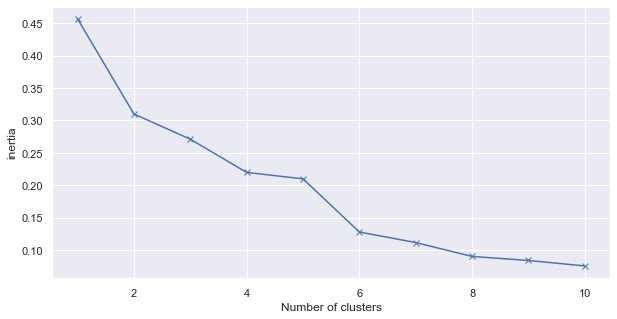

In [ ]:
#elbow method
kList = []
for i in range(1,11):
    elbow = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=50)
    elbow.fit(data)
    kList.append(elbow.inertia_)

plt.plot(range(1, 11), kList, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()
        

In [ ]:
#model
from tslearn.clustering import TimeSeriesKMeans

nc=4
model = TimeSeriesKMeans(n_clusters=nc, metric="dtw", max_iter=50)
model.fit_predict(data)

array([2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
#creating a df from cluster centers
centers = model.cluster_centers_

m,n,r = centers.shape
cluster_arr = np.column_stack((np.repeat(np.arange(m),n),centers.reshape(m*n,-1)))
cluster_df = pd.DataFrame(cluster_arr, columns=['cluster','b_cluster'])

centers.shape

(4, 320, 1)

In [ ]:
cluster_df.dtypes

cluster      float64
b_cluster    float64
dtype: object

In [ ]:
cluster_df = cluster_df.astype({'cluster':'int64','b_cluster':'float64'})
cluster_df.dtypes

cluster        int64
b_cluster    float64
dtype: object

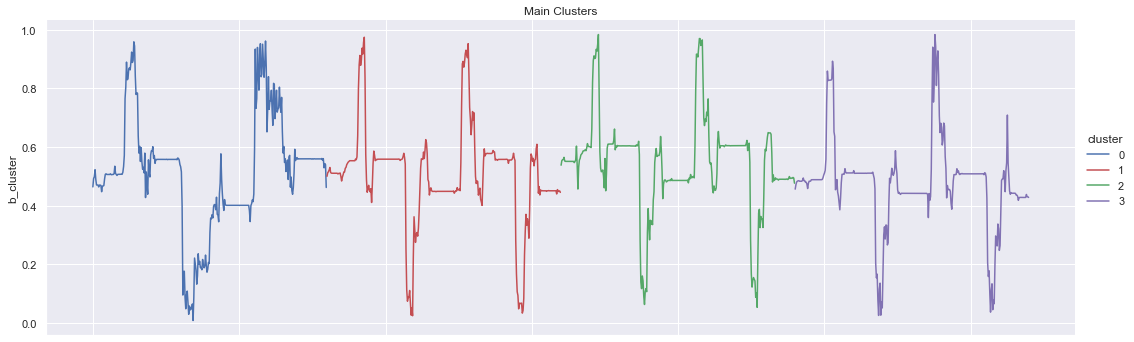

In [ ]:
#visualizing centroid clusters
myPalette = {0:'b', 1:'r', 2:'g', 3:'m', 4:'c', 5:'tab:olive', 6:'tab:purple'}
cluster_list = list(range(1,nc+1))
g = sns.relplot(data=cluster_df, x=cluster_df.index, y='b_cluster', hue='cluster', palette=myPalette, kind='line', aspect=3)
g.set(title='Main Clusters')
g.set(xticklabels=[])
plt.show()

Each color represents a different centroid, now lets identify how frequent and where each cluster is being labeled.

In [ ]:
cluster_df.set_index('cluster', drop=True, append=True,inplace=True)
cluster_df.head()

,,b_cluster
,cluster,
0,0,0.464241
1,0,0.492514
2,0,0.499144
3,0,0.522715
4,0,0.489985


<AxesSubplot:ylabel='cluster'>

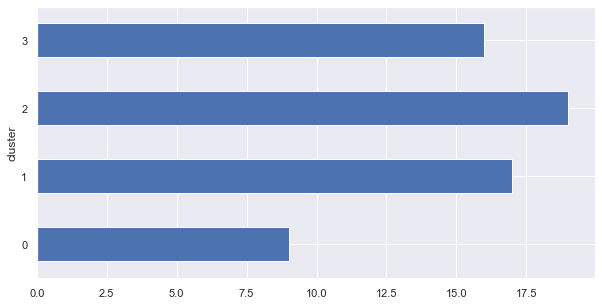

In [ ]:
#visualize cluster population
machine_df = pd.concat(listofdf)
cluster = model.labels_.tolist()
model_df = pd.DataFrame(cluster, columns=['cluster'])

machine_df = machine_df.join(model_df, on='dateId')
machine_df.reset_index(level=1,inplace=True)
machine_df.groupby('cluster')['dateId'].nunique().plot(kind='barh')


These are the frequencies of each centroid

In [ ]:
machine_df.reset_index(drop=True, inplace=True)
machine_df.head()

,dateId,b_axis,cluster
0,0,0.563748,2
1,0,0.561060,2
2,0,0.561252,2
3,0,0.561828,2
4,0,0.569508,2


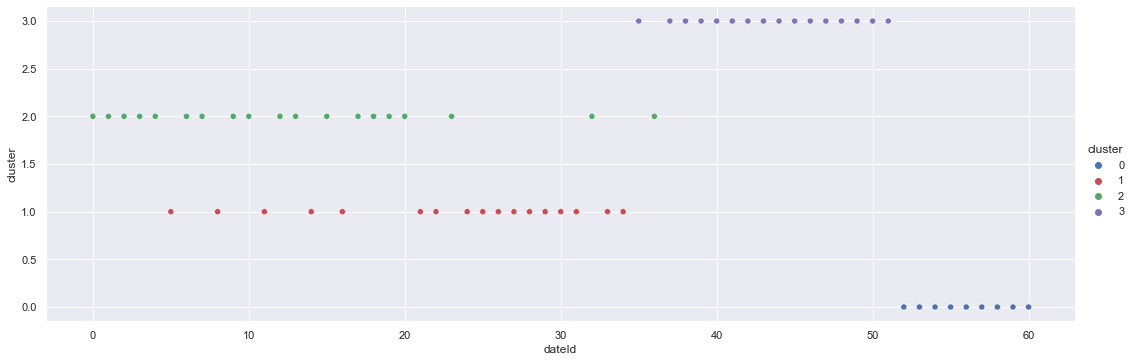

In [ ]:
#timeline of cluster labels
sns.relplot(data=machine_df, x='dateId', y='cluster', hue='cluster', palette=myPalette, kind='scatter', aspect=3)

This is the timeline of the centroids. It appears that the shape of the diagnostic test changes as time goes on. The model varies often from dateId 5-35, so this may indicate malfunctions.

In [ ]:
#create a df for each date ID
date_dict = dict(tuple(machine_df.groupby('dateId')))

In [ ]:
#Finding difference between each dateid and their respective cluster
#euclidean

# differenceDict = {}
# for key in date_dict:
#     a = list(date_dict[key]['b_axis'])
#     b = centers[int(date_dict[key]['cluster'].unique())]
#     differenceDict[key] = np.linalg.norm(a-b)

    

In [ ]:
from tslearn.metrics import dtw
#Finding difference between each dateid and their respective cluster
#dtw

differenceDict = {}
for key in date_dict:
    a = list(date_dict[key]['b_axis'])
    b = centers[int(date_dict[key]['cluster'].unique())]
    differenceDict[key] = dtw(a,b)


In [ ]:
diff = pd.Series(differenceDict, name='dtw_diff')
diff.index.name = 'dateId'
diff = diff.reset_index()
diff

,dateId,dtw_diff
0,0,0.354767
1,1,0.293913
2,2,0.333205
3,3,0.296286
4,4,0.299206
...,...,...
56,56,0.423318
57,57,0.606055
58,58,0.452955
59,59,0.454416


In [ ]:
diff.dtw_diff.describe()

count    61.000000
mean      0.390171
std       0.238652
min       0.191554
25%       0.303676
50%       0.350134
75%       0.387713
max       1.815751
Name: dtw_diff, dtype: float64

In [ ]:
#75th percentile
big_diff = diff[diff['dtw_diff'] > np.quantile(diff.dtw_diff, .75)]

In [ ]:
#25th percentile
small_diff = diff[diff['dtw_diff'] < np.quantile(diff.dtw_diff, .25)]

In [ ]:
#interquartile
low, high = diff.dtw_diff.quantile([0.25,0.75])
middle = diff.query('{low}<dtw_diff<{high}'.format(low=low,high=high))

In [ ]:
for key in date_dict:
    date_dict[key]['centroid'] = centers[int(date_dict[key]['cluster'].unique())]
    date_dict[key].reset_index(drop=True, inplace=True)

We visualize the upper quartile of tests with the greatest difference from their respective cluster centroid

In [ ]:
legend_elements = [plt.Line2D([0], [0], lw=2, color='k', linestyle='--', label='Centroid'),
                    plt.Line2D([0], [0], lw=2, color='k', label='Actual')]

dateId: 32


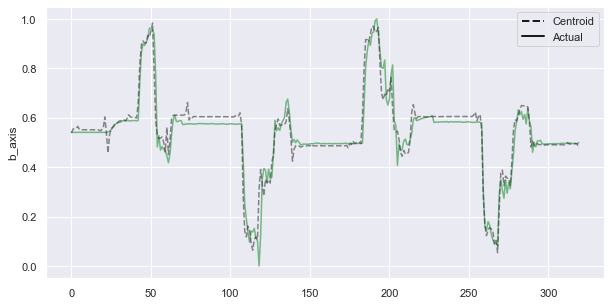

dateId: 35


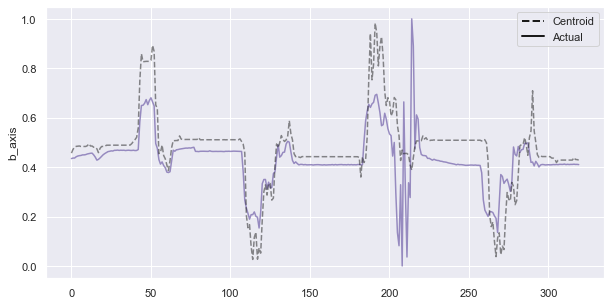

dateId: 36


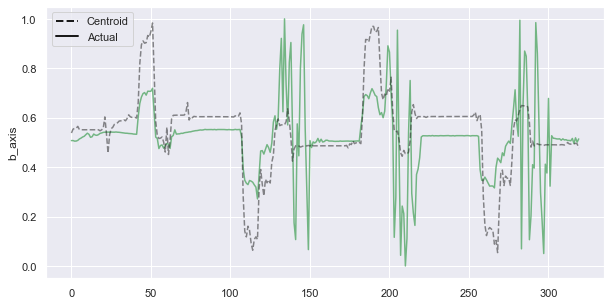

dateId: 39


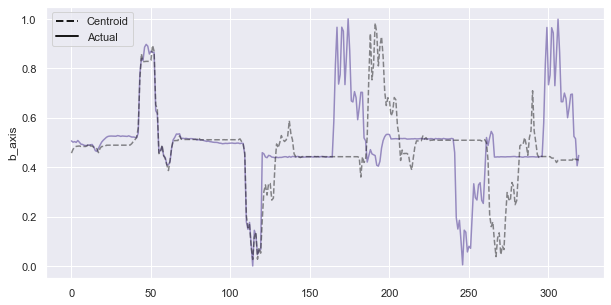

dateId: 41


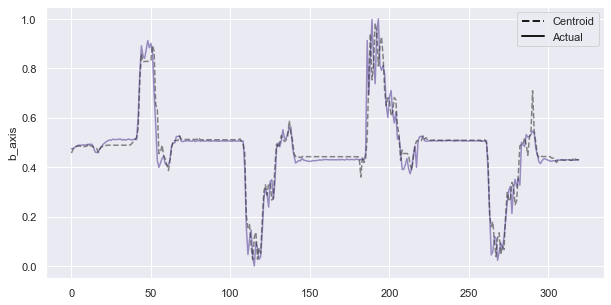

dateId: 50


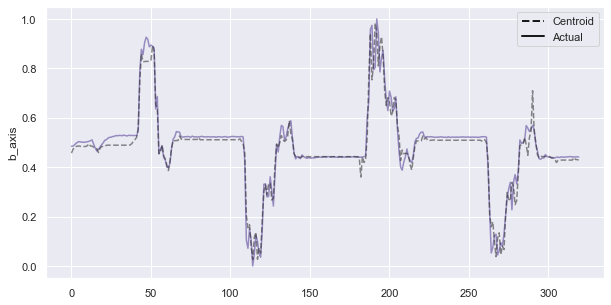

dateId: 51


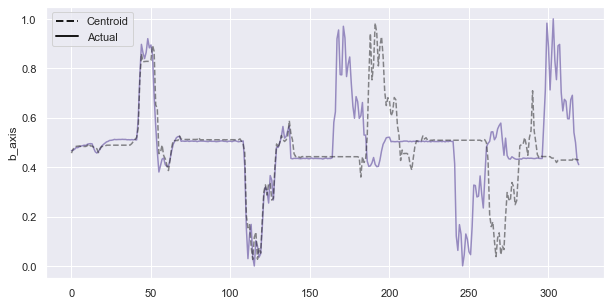

dateId: 52


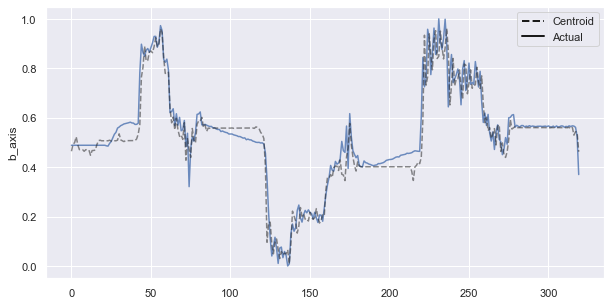

dateId: 54


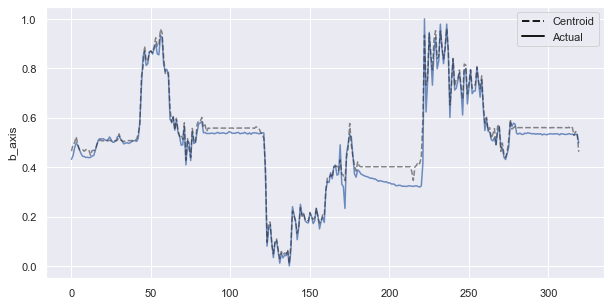

dateId: 55


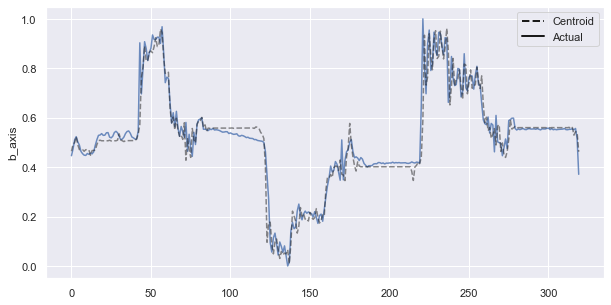

dateId: 56


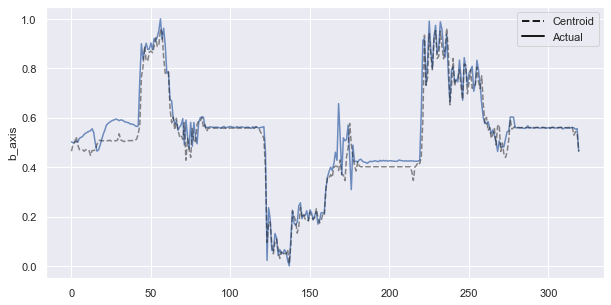

dateId: 57


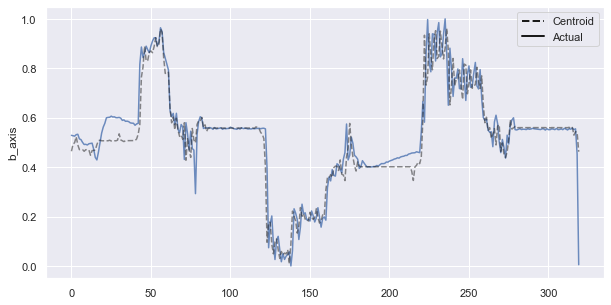

dateId: 58


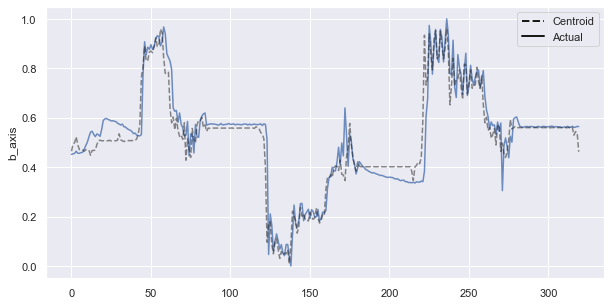

dateId: 59


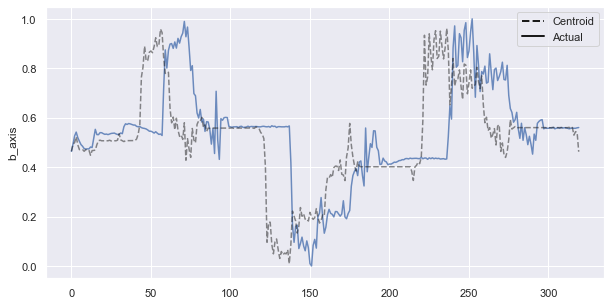

dateId: 60


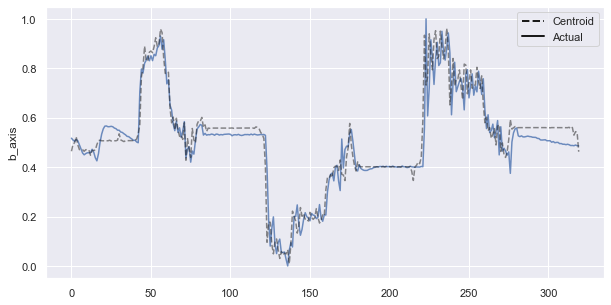

In [ ]:
#visualize upper quartile compared to their respective centroid
diff_list = big_diff['dateId'].to_list()
for key in diff_list:
    print(f'dateId: {key}')
    #plt.plot(date_dict[key].index, date_dict[key].b_axis, )
    sns.set(rc = {'figure.figsize':(10,5)})
    ax1 = sns.lineplot(x=date_dict[key].index, y='b_axis', data=date_dict[key], hue='cluster', palette=myPalette,
                       alpha=0.8, legend=False)
    ax2 = sns.lineplot(x=date_dict[key].index, y='centroid', data=date_dict[key], color='k',
                     linestyle = '--', alpha=0.5, legend=False)
    plt.legend(handles=legend_elements)
    plt.show()

dateId 35 and 36 show great difference from their respective cluster and can be correctly labeled as malfunctions. Other tests have random spikes or have different timing from the centroid, and can not be confidently confirmed as a malfunction. 